In [58]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Reading Data

Original Data

In [90]:
original_data = pd.read_excel('global_warming_tweets.xls')
print(original_data.shape)
original_data.drop(columns=["existence.confidence"], inplace=True)
original_data.drop_duplicates(subset=["tweet"], inplace=True)

data = original_data

print(data.shape)
data.head()

(6090, 3)
(5541, 2)


,tweet,existence
0,Global warming report urges governments to act...,Yes
1,Fighting poverty and global warming in Africa ...,Yes
2,Carbon offsets: How a Vatican forest failed to...,Yes
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness...,Yes


Web Scraped Data

In [16]:
# rawScrapedTweets = []

# with open("scrapedTweets.txt") as fh:
#     d = fh.read()
#     rawScrapedTweets = d.split('\n')

# scrapedTweets = pd.DataFrame(rawScrapedTweets, columns=["tweets"])

# print(scrapedTweets.shape)
# scrapedTweets.head()

## Testing

Data Exploration

<BarContainer object of 2 artists>

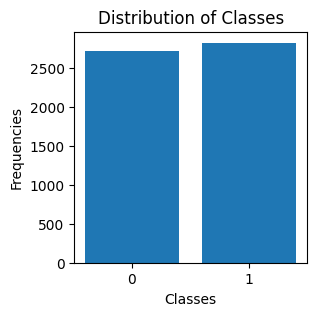

In [62]:
size = len(data["existence"])
cnt = [0, 0]

for val in data["existence"]:
    if pd.isnull(val) or val == "N" or val == "No":
        cnt[0] += 1
    else:
        cnt[1] += 1

plt.figure(figsize=(3,3))
plt.xticks([0,1])
plt.xlabel("Classes")
plt.ylabel("Frequencies")
plt.title("Distribution of Classes")
plt.bar([0, 1], cnt)

Running Algorithms

In [70]:
%run ./jlu_preprocessing.ipynb

X, Y = preprocess(data)
X

In [84]:
def pred(X_train, Y_train, X_test, Y_test, model):
    clf = model.fit(X_train, Y_train)
    pred = model.predict(X_train)
    pred2 = model.predict(X_test)

    plt.plot(cv["train_score"])
    plt.plot(cv["test_score"])
    plt.xlabel("Cross Validation Folds")
    plt.ylabel("Accuracy")
    plt.title("Comparing Performances Across Cross Validation Folds")
    plt.show()

    print("Training accuracy: ", accuracy_score(Y_train, pred))
    print("Testing accuracy: ", accuracy_score(Y_test, pred2))

    conf_mat = confusion_matrix(y_true=Y_train, y_pred=pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    
    conf_mat2 = confusion_matrix(y_true=Y_test, y_pred=pred2)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2)
    disp2.plot()

In [74]:
X_ = TruncatedSVD(n_components=4000).fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, test_size=0.2)

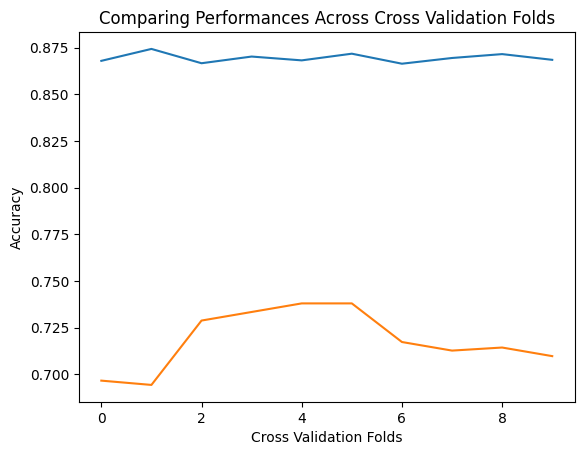

Training accuracy:  0.9376522162688748
Testing accuracy:  0.697176241480039


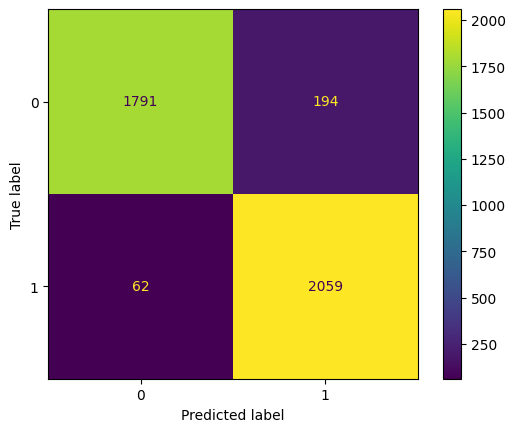

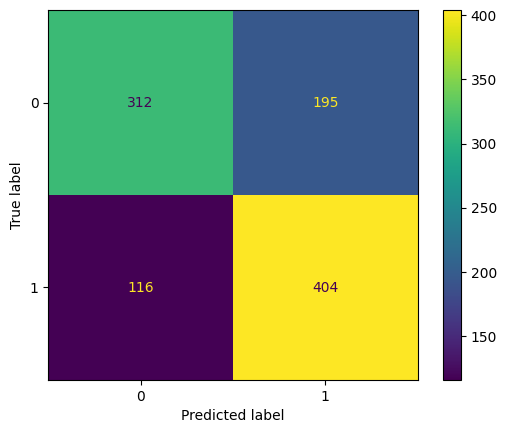

In [85]:
model = pred(X_train, Y_train, X_test, Y_test, Perceptron())

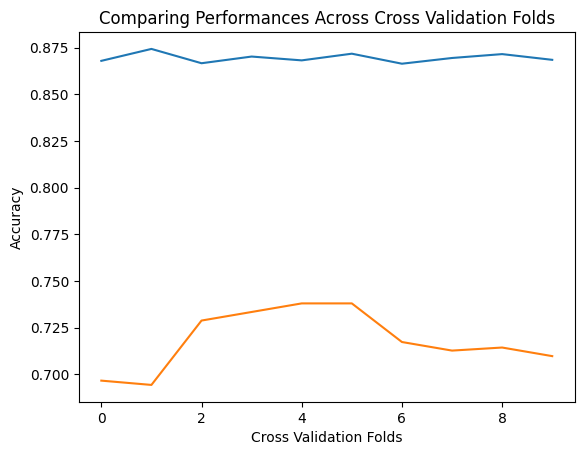

Training accuracy:  0.871651242084754
Testing accuracy:  0.7147030185004869


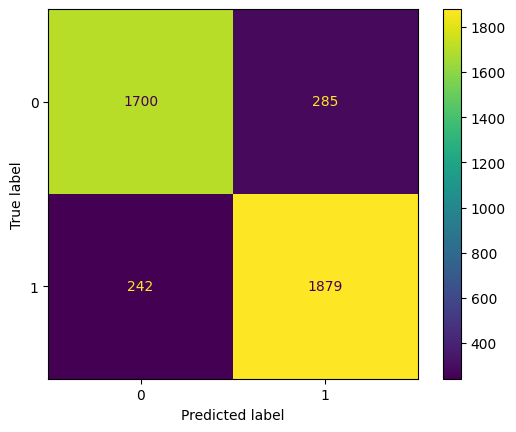

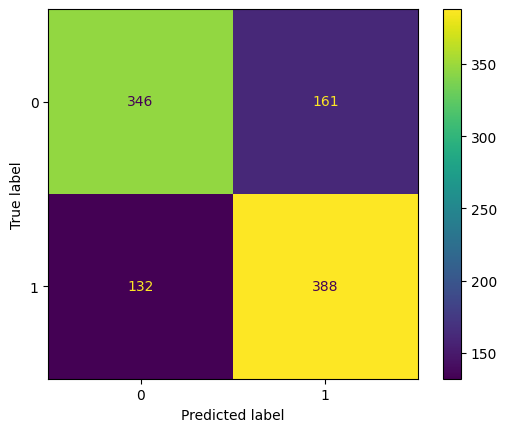

In [86]:
model = pred(X_train, Y_train, X_test, Y_test, LogisticRegression())

In [54]:
def testSVD(X, Y, n_components):
    X_ = TruncatedSVD(n_components=n_components).fit_transform(X)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, test_size=0.2)

    model = LogisticRegression()

    num_cv = 5
    
    cv = cross_validate(model, X_train, Y_train, cv=num_cv, return_estimator=True, return_train_score=True, n_jobs=-1)
    
    return np.sum(cv["test_score"])/num_cv
    
    # clf = model.fit(X_train, Y_train)
    # pred = model.predict(X_test)

    # return accuracy_score(Y_test, pred)

1000  |  0.7182164649958065
2000  |  0.7006768791249174
3000  |  0.7079841508338001
4000  |  0.7167512765572812
5000  |  0.7072616327486212


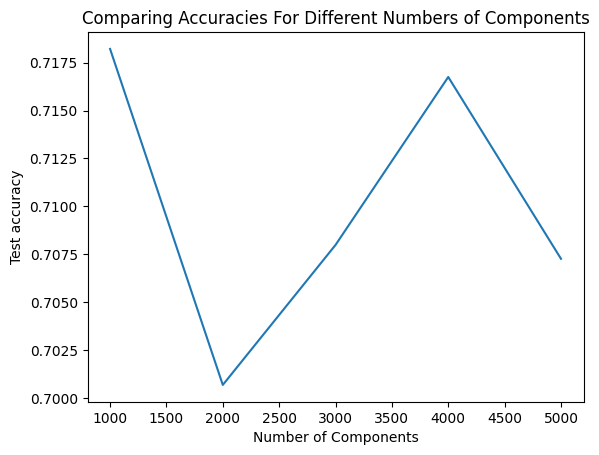

In [69]:
components = np.arange(1000,6000,1000)
scores = []
for num in components:
    score = testSVD(X, Y, num)
    scores.append(score)
    
    print(num, " | ", score)
    
plt.plot(components, scores)
plt.ylabel("Test accuracy")
plt.xlabel("Number of Components")
plt.title("Comparing Accuracies For Different Numbers of Components")
plt.show()